# Support Vector Machines

Support Vector Machines (or SVM) are a family of supervised learning models for classification or regression. SVM is part of the family of linear predictors, since it search for halfspaces able to separate the points. Moreover, the SVM algorithmic paradigm tackles the sample complexity challenge by searching for *large margin* separators.

## Hard-SVM
Givent a set of points $S = \{(\mathbf x_1, y_1), \ldots, (\mathbf x_m, y_m)\}$ we say that this points are linearly separable if there exists an halfspace $(\mathbf w, b)$ such that:

$$ \forall u\in[m],\quad y_i(\langle\mathbf w, \mathbf x_i\rangle+b) > 0 $$

For any separable training sample, there are many possible solutions. However we want to find the one that gives us the most reliable results.
We can formalize this intuition introducing the concept of *margin*

> The margin of an hyperplane with respect to a training set is defined as the minimal distance between a point in the training set and the hyperplane

**Hard-SVM** is the learning rule in which we return an ERM hyperplane that separates the training set with largest possible margin.
Mathematiccaly we can formalize this problem as:

$$ \underset{(\mathbf w, b):\|\mathbf w\|=1}{\arg\max} \underset{i\in[m]}{\min}|\langle\mathbf w, \mathbf x_i\rangle+b|\quad s.t. \quad \forall i\in[m],\quad y_i(\langle\mathbf w, \mathbf x_i\rangle+b) > 0$$

where $|\langle\mathbf w, \mathbf x_i\rangle+b|$ is the distance between point $\mathbf x_i$ and the hyperplane defined by $(\mathbf w, b)$. The formula simply tells us that we want to find the vector $\mathbf w$ of norm 1 that maximizes the minimum distance of a point from the corresponding hyperplane, such that all points are corretcly classified.

In the separable case we can write equivalently:

$$ \underset{(\mathbf w, b):\|\mathbf w\|=1}{\arg\max} \underset{i\in[m]}{\min}y_i(\langle\mathbf w, \mathbf x_i\rangle+b)$$


Finally, another semplification of the problem is done considering the homogeneous case, namely, considering halfspaces that pass through the origin point and thus omitting the bias term $b$. Note that we can reduce nonhomogeneous halfspaces adding the bias term to the weight vector and extending each sample with a symbolic entry of value 1:

$$ \mathbf w= (b, w_1, \ldots, w_d),\qquad \mathbf x_i = (1, x_{i,1 },\ldots, x_{d, 1}) $$

In this case the problem becomes simply:

$$ \underset{\mathbf w}{\min}\|\mathbf w\|^2\quad s.t.\quad \forall i\in[m],\quad y_i\langle\mathbf w, \mathbf x_i\rangle\ge 1$$

### Implementation
Another equivalent formulation of the same problem can by given in the form of a quadratic optimization problem

$$ \underset{(\mathbf w, b)}{\arg\min }\|\mathbf w\|^2 \quad s.t.\quad \forall i \in[m], \quad y_i(\langle\mathbf w, \mathbf x_i\rangle+b) > 0 $$

The idea is to fix the minimum margin to 1 and then using the vector $\mathbf w$ to scale the distances. Minimizing the squared norm (the length) of the vector, we practically maximize the distances and so the margins. Hence, solving this problem we have found the maximum margin halfspace

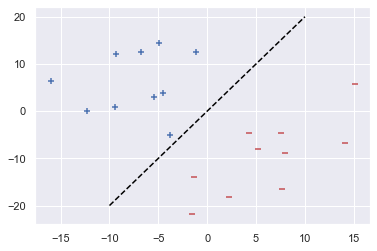

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

separating_line = lambda x: 2*x + 0

n_pos_points = 10
n_neg_points = 10

x_pos = np.array([(x - 15*np.random.rand(), separating_line(x) + 15*np.random.rand()) for x in np.random.randint(-5, 5, n_pos_points)])
x_neg = np.array([(x + 15*np.random.rand(), separating_line(x) - 15*np.random.rand())for x in np.random.randint(-5, 5, n_pos_points)])

plt.scatter(x_pos[:,0], x_pos[:,1], c='b', marker='+')
plt.scatter(x_neg[:,0], x_neg[:,1], c='r', marker='_')
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')
plt.show()

X = np.vstack((x_pos, x_neg)) #points
y = np.hstack((np.ones(len(x_pos)), -1 * np.ones(len(x_neg)))) #labels


In [21]:
import scipy as sp
from scipy.optimize import LinearConstraint


class SVM():
    
    def fit(self, X, y):
        constraints = LinearConstraint(X*y[:,np.newaxis], np.ones(len(X)), np.full(len(X), np.inf))
        self.res = sp.optimize.minimize(sp.linalg.norm, np.random.rand(2),  constraints=[constraints])
        
    def transform(self, X):
        return np.sign(self.res.x @ X.T)

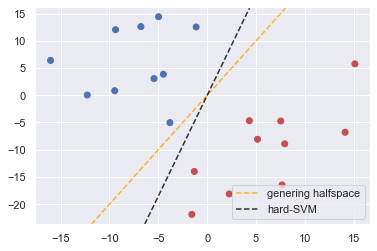

In [25]:
model = SVM()
model.fit(X, y)
y_pred = model.transform(X)

colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c=colors)
# plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')
w = model.res.x
d = -w[0]/w[1]
plt.axline((0, 0), slope = 2,  linestyle='--', color='orange', alpha=0.8, label ='genering halfspace')
plt.axline((0, 0), slope = d,  linestyle='--', color='black', alpha=0.8, label ='hard-SVM')

plt.legend()


## Soft-SVM

The assumption made in the case of hard-SVM is that the realizability assumption holds or simply that the point are linearly separable. This is a rather strong assumption that limits a lot the usefulness of this algorithm. Soft-SVM is a relaxation of the Hard-SVM rule, that can be applied even if the training set is not linearly separable.

The idea is simple: we allow the model to commit *some* errors in the classification

This 'some' is quantified introducing nonnegative slack variables $\xi_1, \ldots \xi_m$, and defining the classification constraints as:

$$  y_i\langle\mathbf w, \mathbf x_i\rangle\ge 1 - \xi_i $$

That is, each slack variable measure how much the constraint $ y_i\langle\mathbf w, \mathbf x_i\rangle\ge 1$ (correct classification) is being violated. Obviously, even if we allow the model to commit errors, we want to minimize them. Hence, we want at the same time minimize the norm of $\mathbf w$ and the average of the slacks variables:

$$ \underset{\mathbf w, \mathbf \xi}{\min} \big(\lambda\|\mathbf w\|^2+\frac{1}{m}\sum_{i=1}^m\xi_i\big)
\quad s.t\quad \forall i\in[m], y_i\langle\mathbf w, \mathbf x_i\rangle \ge 1 - \xi_i \text{ and } \xi_i \ge 0
$$

We can rewrite the equation above as a regularize loss minimization problem, recalling the definition of *hinge loss*:

$$ l^{hinge} (\mathbf w, \mathbf x, y) = \max\{0, 1 - y\langle \mathbf w, \mathbf x \rangle\} $$

Considering a training set $S$ we can define $L_S^{hinge}(\mathbf w) $ as the averaged hinge loss on $S$ and we have that the Soft-SVM problem can be written as the following regularized loss minimization problem:

$$ \underset{\mathbf w}{\min}\big(\lambda \|\mathbf w\|^2 + L_S^{hinge}(\mathbf w) \big ) $$

> Soft-SVM falls into the paradigm of regularized loss minimization


### Implementation

Soft-SVM problem is a Linear Program and so it can be expressed in its dual form:

$$ \underset{\mathbf \alpha \in \mathbb R ^m : \mathbf \alpha \ge \mathbf 0}{\max}\underset{\mathbf w}{\min}\Big(\frac{1}{2}\|\mathbf w\|^2  + \sum_{i=1}^m \alpha_i(1 - y_i\langle \mathbf w , \mathbf x_i\rangle)\Big ) $$

Note that once fixed the vector $\mathbf \alpha$, the optimization problem with respect to $\mathbf w$ is unconstrained and the objective is differentiable; thus at the optimum, the gradient equals zero:

$$ \mathbf w -\sum_{i=1}^m\alpha_iy_i\mathbf x_i = 0 \quad \Rightarrow \quad \mathbf w = \sum_{i=1}^m\alpha_iy_i\mathbf x_i $$

What this equation practically tells us is that the solution must be in the linear span of the examples. Plugging this result in the previous equation we obtain:

$$ \underset{\mathbf \alpha \in \mathbb R ^m : \mathbf \alpha \ge \mathbf 0}{\max}\underset{\mathbf w}{\min}\Bigg(\frac{1}{2}\Big\| \sum_{i=1}^m\alpha_iy_i\mathbf x_i\Big\|^2  + \sum_{i=1}^m \alpha_i\Big(1 - y_i\langle \sum_{j=1}^m\alpha_jy_j\mathbf x_j , \mathbf x_i\rangle\Big)\Bigg ) $$

Rearraging we can write:

$$ \underset{\mathbf \alpha \in \mathbb R ^m : \mathbf \alpha \ge \mathbf 0}{\max} \Big ( \sum_{i=1}^m\alpha_i - \frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha_i\alpha_jy_iy_j\langle \mathbf x_j, \mathbf x_i \rangle\Big) $$

> Note that the dual problem involves an inner product $\langle \mathbf x_j, \mathbf x_i \rangle$ and does not require direct access to specific elements within an instance

In [121]:
def dual(alpha, X, y):
    m = len(X)
    sum = 0
    for i in range(m):
        for j in range(m):
            sum += alpha[i] * alpha[j] * y[i] * y[j] * X[i].dot(X[j])

    return -np.sum(alpha) + 1/2 * sum

from scipy.optimize import Bounds
class soft_SVM():
    def fit(self, X, y):
        m = len(X)
        [[1, 2], [2, 1]], [-np.inf, 1], [1, 1]
#         constraints = LinearConstraint(np.ones(m)[:, np.newaxis], np.zeros(m)[:, np.newaxis], np.full(m, np.inf)[:, np.newaxis])
        
        bounds = Bounds(np.zeros(m), np.full(m, np.inf))
        self.res = sp.optimize.minimize(dual, np.random.rand(m).reshape(1, -1), constraints=[], args=(X, y), bounds=bounds)
        self.compute_w(X, y)
        
    def compute_w(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n)
        
        for i in range(m):
            self.w += self.res.x[i] * y[i] * X[i]
    
    def sgd(self,X,y,lam,T=1000):
        m,n = X.shape
        theta = np.zeros(n)
        w_sum = np.zeros(n)
        
        for t in range(1, T):
            w_t = theta/(lam * t)
            w_sum += w_t
            i = np.random.randint(0, m)
            
            if y[i] *(np.dot(X[i], w_t)) < 1:
                theta = theta + y[i] * X[i]
        
        self.w = w_sum/T
                
    def transform(self, X):
        return np.sign(self.w @ X.T)

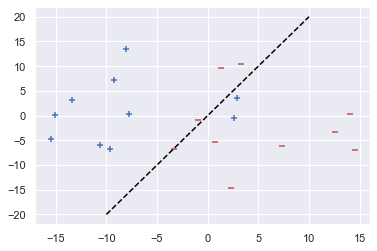

In [138]:
separating_line = lambda x: 2*x + 0

n_pos_points = 10
n_neg_points = 10

x_pos = np.array([(x - 15*np.random.rand() + 8 * np.random.rand(), separating_line(x) + 15*np.random.rand() - 7 * np.random.rand()) for x in np.random.randint(-5, 5, n_pos_points)])
x_neg = np.array([(x + 15*np.random.rand() - 8 * np.random.rand(), separating_line(x) - 15*np.random.rand() + 7 * np.random.rand()) for x in np.random.randint(-5, 5, n_pos_points)])

plt.scatter(x_pos[:,0], x_pos[:,1], c='b', marker='+')
plt.scatter(x_neg[:,0], x_neg[:,1], c='r', marker='_')
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')
plt.show()


X = np.vstack((x_pos, x_neg)) #points
y = np.hstack((np.ones(len(x_pos)), -1 * np.ones(len(x_neg)))) #labels

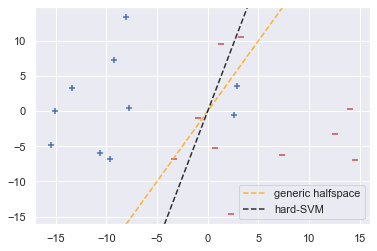

In [139]:
model = soft_SVM()
model.sgd(X, y, lam = 10)
y_pred = model.transform(X)

# colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
# plt.scatter(X[:,0], X[:,1], c=colors)
plt.scatter(x_pos[:,0], x_pos[:,1], c='b', marker='+')
plt.scatter(x_neg[:,0], x_neg[:,1], c='r', marker='_')
# plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')
w = model.w
d = -w[0]/w[1]
plt.axline((0, 0), slope = 2,  linestyle='--', color='orange', alpha=0.8, label ='generic halfspace')
plt.axline((0, 0), slope = d,  linestyle='--', color='black', alpha=0.8, label ='hard-SVM')

plt.legend()
